In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy import stats
import matplotlib.dates as mdates
import os
import glob
import re
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#Constant variables
month = {
                'Jan' : '01',
                'Feb' : '02',
                'Mar' : '03',
                'May' : '04',
                'Apr' : '05',
                'Jun' : '06',
                'Jul' : '07',
                'Aug' : '08',
                'Sep' : '09',
                'Oct' : '10',
                'Nov' : '11',
                'Dec' : '12',  
}

In [3]:
def format_date(date):
    if re.search('\w+ \d\d, \d\d\d\d',date):
        x = date.split(' ')
        x[0] = month[x[0]]
        x[1] = x[1][0] + x[1][1]
        date = x[2]+'-'+x[0]+'-'+x[1]
    return date

# Use 2016-2019 Data to predict 2020's Gold Price

## import dataset

In [4]:
gold =pd.read_csv("./dataset/gld_price_data.csv")
gas =pd.read_csv("./dataset/natural_gas_data.csv")
oil = pd.read_csv('./dataset/crude_oil_eu_data.csv')
dolla = pd.read_csv('./dataset/dolla_index_data.csv')
etf = pd.read_csv('./dataset/etf_data.csv')
bond = pd.DataFrame(pd.read_csv('./dataset/bond_data.csv'),columns={'Date','Price'})
sil = pd.DataFrame(pd.read_csv('./dataset/silver_price_data.csv'), columns={'Date','USD'})
bit = pd.DataFrame(pd.read_csv('./dataset/bit_data.csv'), columns={'Date','Close'})

In [5]:
sil = sil[['Date','USD']]
bit = bit[['Date','Close']]
bond = bond[['Date','Price']]

In [6]:
d = []
for i in bond['Date']:
    d.append(format_date(i))
d = pd.Series(d)
bond['Date'] = d

## data preprocessing

In [7]:
### daily data only
### df : list of dataframe , name : list of dataframe's value's name , color : list of data's color
df = [gold,gas,oil,dolla,etf,bond,sil,bit]
columnName = ['gld_price', 'gas_price', 'oil_price','dolla_index','etf_index','bond_yield','silver_price','bitcoin_price']
color = ['red', 'green', 'blue', 'violet','purple','gray','silver','gold']

In [8]:
### rename all data columns
for i in range(len(df)):
    df[i] = df[i].rename(columns={df[i].columns[0]:'date',df[i].columns[1]:columnName[i]})

In [9]:
### set date as index and join all data
data = df[0].set_index('date')
for i in range(len(df)):
    if i > 0:
        data = data.join(df[i].set_index('date'))

In [10]:
data

,gld_price,gas_price,oil_price,dolla_index,etf_index,bond_yield,silver_price,bitcoin_price
date,,,,,,,,
2016-02-19,1231.15,1.83,31.66,113.9502,24.88,NaN,15.37,420.785004
2016-02-19,1267.00,1.83,31.66,113.9502,24.88,NaN,15.37,420.785004
2016-02-22,1211.00,1.86,33.59,113.8157,23.31,NaN,15.00,437.747986
2016-02-23,1221.35,1.85,31.90,114.1686,23.69,NaN,15.21,420.735992
2016-02-24,1250.75,1.85,31.50,114.163,24.24,NaN,15.32,424.954987
2016-02-25,1236.00,1.78,32.83,113.916,23.36,NaN,15.16,424.544006
2016-02-26,1226.50,1.78,35.76,114.365,21.67,NaN,15.17,432.152008
2016-02-29,1234.90,1.62,35.92,114.2359,22.59,NaN,14.75,437.696991
2016-03-01,1236.50,1.57,35.73,113.9208,21.97,1.827,14.99,435.122986


In [11]:
data = data.replace('.', np.NaN)

In [12]:
data = data.dropna()

In [13]:
### convert index to datetime64
data = pd.DataFrame(data, index = np.array([np.datetime64(i) for i in data.index]))

In [14]:
### convert all data values to float
for i in data.columns:
    data[i] = data[i].astype(str).astype(float)

In [15]:
data.head(5)

,gld_price,gas_price,oil_price,dolla_index,etf_index,bond_yield,silver_price,bitcoin_price
2016-03-01,1236.50,1.57,35.73,113.9208,21.97,1.827,14.99,435.122986
2016-03-02,1239.20,1.60,36.38,113.7902,22.00,1.835,14.82,423.989014
2016-03-03,1250.25,1.59,35.75,113.2419,23.51,1.835,14.97,421.651001
2016-03-04,1277.50,1.49,37.61,112.6317,22.31,1.876,15.43,410.938995
2016-03-07,1267.90,1.56,39.02,112.6166,22.08,1.904,15.66,414.321014


## DATA EXPLORATION

In [16]:
#normalization and plot function
def plot_df(data,columns):
    plt_data = data.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    for i in data.columns:
        scale = min_max_scaler.fit_transform(plt_data[i].values.reshape(-1,1))
        temp = pd.DataFrame(scale, columns=[i], index = data.index)
        plt_data[i] = temp
    ax = plt.gca()
    plt_data.plot(kind='line', y='gld_price',ax=ax,color='blue',figsize=(10,5))
    plt_data.plot(kind='line', y=columns,ax=ax,color='red')
    plt.show()

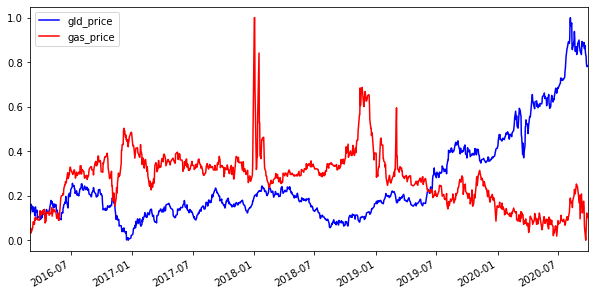

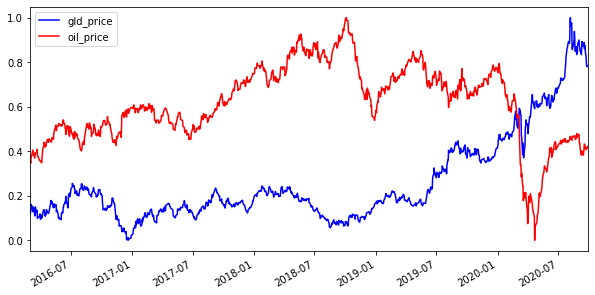

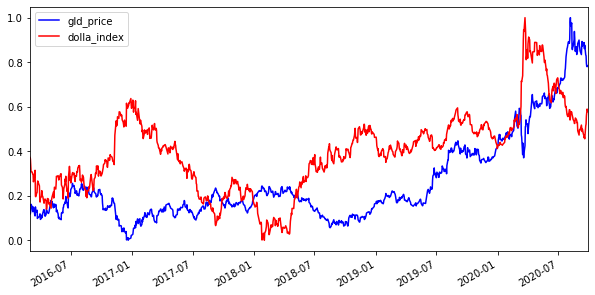

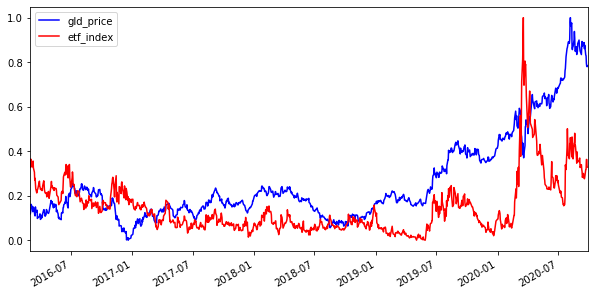

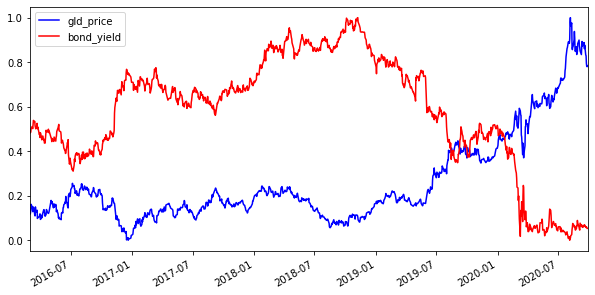

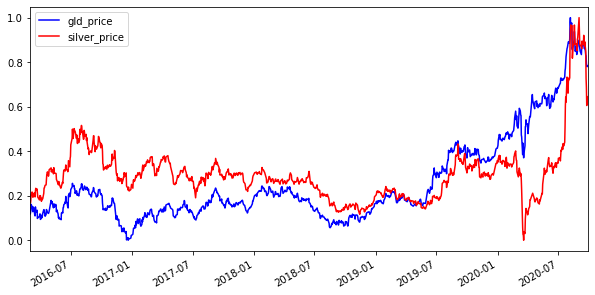

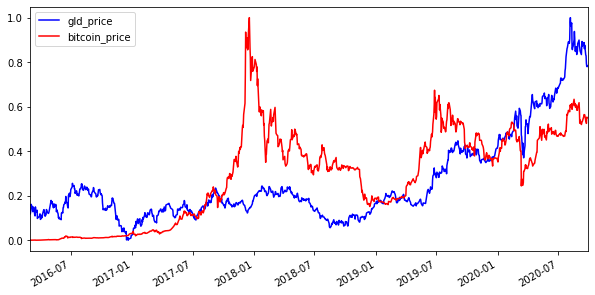

In [17]:
#plot all feature
for i in data.columns:
    if i != 'gld_price':
        plot_df(data,i)

## CORRELATION

In [18]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,gld_price,gas_price,oil_price,dolla_index,etf_index,bond_yield,silver_price,bitcoin_price
gld_price,1,-0.618284,-0.405689,0.506717,0.552617,-0.815483,0.649446,0.54993
gas_price,-0.618284,1,0.439112,-0.338013,-0.506168,0.685286,-0.241628,-0.233532
oil_price,-0.405689,0.439112,1,-0.379612,-0.737112,0.75894,-0.335208,0.306595
dolla_index,0.506717,-0.338013,-0.379612,1,0.499,-0.515272,0.0451954,0.136418
etf_index,0.552617,-0.506168,-0.737112,0.499,1,-0.72687,0.322043,0.00792396
bond_yield,-0.815483,0.685286,0.75894,-0.515272,-0.72687,1,-0.580006,-0.15045
silver_price,0.649446,-0.241628,-0.335208,0.0451954,0.322043,-0.580006,1,0.136656
bitcoin_price,0.54993,-0.233532,0.306595,0.136418,0.00792396,-0.15045,0.136656,1


In [19]:
## drop unusable  feature
data = data.drop(columns=[data.columns[i] for i in []])

## GRANGER CAUSATION TEST

In [20]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [21]:
granger = grangers_causation_matrix(data, variables = data.columns)

In [22]:
granger

,gld_price_x,gas_price_x,oil_price_x,dolla_index_x,etf_index_x,bond_yield_x,silver_price_x,bitcoin_price_x
gld_price_y,1.0000,0.3130,0.0444,0.0051,0.0000,0.0000,0.0000,0.2165
gas_price_y,0.0000,1.0000,0.0226,0.1372,0.0094,0.0000,0.1739,0.0000
oil_price_y,0.0000,0.3027,1.0000,0.0161,0.0000,0.0080,0.1928,0.0078
dolla_index_y,0.0005,0.0403,0.0334,1.0000,0.0000,0.0017,0.0062,0.1445
etf_index_y,0.0000,0.0082,0.0007,0.0455,1.0000,0.0000,0.0015,0.0002
bond_yield_y,0.0007,0.1617,0.0652,0.0214,0.0000,1.0000,0.0015,0.1494
silver_price_y,0.0000,0.1995,0.0279,0.0000,0.0002,0.0000,1.0000,0.1846
bitcoin_price_y,0.0112,0.0389,0.3891,0.1856,0.0994,0.0361,0.4718,1.0000


In [23]:
## drop unusable  feature
data = data.drop(columns=[data.columns[i] for i in [1,7]])

In [24]:
data

,gld_price,oil_price,dolla_index,etf_index,bond_yield,silver_price
2016-03-01,1236.50,35.73,113.9208,21.97,1.827,14.990
2016-03-02,1239.20,36.38,113.7902,22.00,1.835,14.820
2016-03-03,1250.25,35.75,113.2419,23.51,1.835,14.970
2016-03-04,1277.50,37.61,112.6317,22.31,1.876,15.430
2016-03-07,1267.90,39.02,112.6166,22.08,1.904,15.660
2016-03-09,1246.40,40.26,112.4212,22.31,1.879,15.270
2016-03-10,1266.50,38.63,112.4122,23.14,1.936,15.270
2016-03-11,1264.75,39.41,111.7351,21.90,1.980,15.500
2016-03-14,1242.75,38.06,112.1613,21.14,1.961,15.600
2016-03-15,1232.00,37.49,112.5466,19.70,1.968,15.320


## COINTEGRATION TEST

In [25]:
cointegration_test(data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
gld_price ::  97.09     > 83.9383   =>   True
oil_price ::  48.41     > 60.0627   =>   False
dolla_index ::  26.23     > 40.1749   =>   False
etf_index ::  6.52      > 24.2761   =>   False
bond_yield ::  2.09      > 12.3212   =>   False
silver_price ::  0.45      > 4.1296    =>   False


In [26]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [27]:
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "gld_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.749
 No. Lags Chosen       = 6
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.9908. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "oil_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9128
 No. Lags Chosen       = 0
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.3261. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "dolla_index" 
    -----------------------------------------------
 Null Hypothesis: D

In [28]:
## 1st Diff
df_diff = data.diff().dropna()

In [29]:
for name, column in df_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "gld_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.2263
 No. Lags Chosen       = 5
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "oil_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.485
 No. Lags Chosen       = 2
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dolla_index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significanc

In [30]:
#  #2nd diff
#  df_differenced = df_differenced.diff().dropna()
#  for name, column in df_differenced.iteritems():
#      adfuller_test(column, name=column.name)
#      print('\n')

In [31]:
year = {str(i):0 for i in range(2015,2021)}
for i in data.index:
    for key in year:
        if key in str(i):
            year[key] += 1

In [32]:
year

{'2015': 0, '2016': 197, '2017': 235, '2018': 231, '2019': 233, '2020': 173}

In [33]:
x = df_diff[:-year['2020']]
y = df_diff[-year['2020']:]

In [34]:
print(len(x))

895


In [35]:
print(len(y))

173


# Create VAR model

In [36]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [37]:
nobs = 7
n = len(x)
pred = pd.DataFrame()
lag = []
for i in range(n+1,len(df_diff)-7,7):
    df_x = df_diff[i-n-1:i-1]
    df_y = df_diff[i:i+7]['gld_price']
    model = VAR(df_x)
    aic = {'n': 1, 'value':999999999}
    for j in range(5,15):
        result = model.fit(j)
        if result.aic < aic['value']:
            aic['n'] = j
            aic['value'] = result.aic
    print(aic)
    lag.append(aic['n'])
    model_fitted = model.fit(aic['n'])
    lag_order = model_fitted.k_ar
    forecast_input = df_diff.values[-lag_order:]
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_forecast = pd.DataFrame(fc, index=df_y.index[-nobs:], columns=df_diff.columns + '_1d')
    df_results = invert_transformation(data[i-n-1:i-1], df_forecast, second_diff=False)  
    pred = pred.append(df_results.loc[:, ['gld_price_forecast']])

C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{'n': 6, 'value': -7.890051742746618}
{'n': 6, 'value': -7.933127194503527}

C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



{'n': 6, 'value': -7.9687745919132436}
{'n': 6, 'value': -7.977389339080778}
{'n': 6, 'value': -8.016529797101361}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

{'n': 6, 'value': -8.040009204483976}
{'n': 6, 'value': -7.892817265663577}
{'n': 6, 'value': -7.435627373678617}
{'n': 8, 'value': -6.836472797667227}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

{'n': 11, 'value': -6.789780298306082}
{'n': 11, 'value': -6.55878091730329}
{'n': 11, 'value': -6.424131904879309}
{'n': 11, 'value': -6.360656221674068}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{'n': 11, 'value': -6.338024704888623}
{'n': 11, 'value': -6.314393823491291}
{'n': 11, 'value': -6.270276094578318}
{'n': 11, 'value': -6.283318016247992}

C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig


{'n': 11, 'value': -6.261928888204107}
{'n': 11, 'value': -6.2394051033593545}
{'n': 11, 'value': -5.906583452058895}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{'n': 10, 'value': -5.718308154481022}
{'n': 11, 'value': -5.451513216856391}
{'n': 14, 'value': -5.465843908680503}
{'n': 11, 'value': -5.458961484281778}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [38]:
lagc = {i:0 for i in range(5,15)}
for i in lag:
    if i in range(5,15):
        if i in lagc:
            lagc[i] += 1
        else:
            lagc[i] = 1

<BarContainer object of 10 artists>

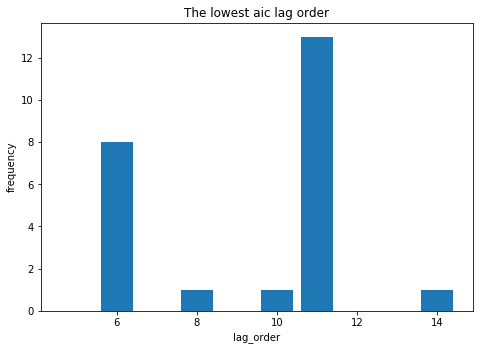

In [39]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('lag_order')
ax.set_ylabel('frequency')
ax.set_title('The lowest aic lag order')
ax.bar(list(lagc.keys()),list(lagc.values()),)

In [40]:
test_data = pd.DataFrame(data[-year['2020']:]['gld_price'])

In [41]:
pred

,gld_price_forecast
2020-01-03,1516.095475
2020-01-06,1512.878818
2020-01-07,1521.627766
2020-01-08,1519.602240
2020-01-09,1520.641915
2020-01-10,1523.030303
2020-01-13,1522.003971
2020-01-14,1549.115630
2020-01-15,1543.800503
2020-01-16,1550.109630


In [42]:
pred['gld_price_forecast'][0]

1516.0954750554401

In [43]:
def change_trend_cal(df):
    percent_change = [0]
    trend = [0]
    for i in range(len(df)):
        if i > 0:
            pc = (df[df.columns[0]][i] - df[df.columns[0]][i-1])/df[df.columns[0]][i-1]*100
            percent_change.append(pc)
            trend.append(pc/abs(pc))
    
    percent_change = pd.Series(percent_change, index=df.index)
    trend = pd.Series(trend, index=df.index)
    df['%Change'] = percent_change
    df['Trend'] = trend

In [44]:
change_trend_cal(pred)
change_trend_cal(test_data)

In [45]:
pred.head(5)

,gld_price_forecast,%Change,Trend
2020-01-03,1516.095475,0.000000,0.0
2020-01-06,1512.878818,-0.212167,-1.0
2020-01-07,1521.627766,0.578298,1.0
2020-01-08,1519.602240,-0.133116,-1.0
2020-01-09,1520.641915,0.068418,1.0


In [46]:
test_data.head(5)

,gld_price,%Change,Trend
2020-01-02,1527.10,0.000000,0.0
2020-01-03,1548.75,1.417720,1.0
2020-01-06,1573.10,1.572236,1.0
2020-01-07,1567.85,-0.333736,-1.0
2020-01-08,1571.95,0.261505,1.0


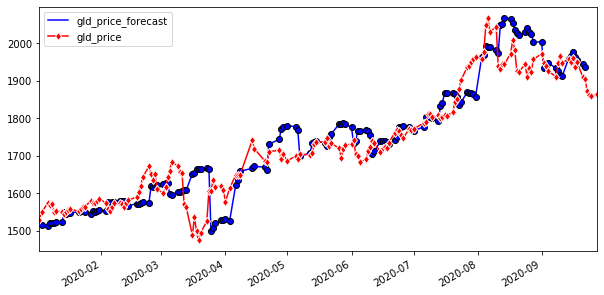

In [47]:
ax = plt.gca()
pred.plot(kind='line', y='gld_price_forecast',ax=ax,color='blue',figsize=(10,5),marker='o',markeredgecolor="black")
test_data.plot(kind='line', y='gld_price',ax=ax,color='red',marker='d',markeredgecolor="white")
plt.show()

## Evaluate Model

In [48]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: gld_price')
accuracy_prod = forecast_accuracy(pred['gld_price_forecast'].values, test_data[:len(pred)]['gld_price'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: gld_price
mape :  0.0249
me :  9.5568
mae :  42.8354
mpe :  0.0055
rmse :  58.2599
corr :  0.9343
minmax :  0.0241


In [49]:
test_data[-20:-13]

,gld_price,%Change,Trend
2020-08-28,1957.35,1.741300,1.0
2020-09-01,1972.35,0.766342,1.0
2020-09-02,1947.05,-1.282734,-1.0
2020-09-03,1940.45,-0.338974,-1.0
2020-09-04,1926.30,-0.729212,-1.0
2020-09-08,1910.95,-0.796864,-1.0
2020-09-09,1947.20,1.896962,1.0


# Use 01/03/2016-31/02/2021 Data to Predict 01/03/2021-08/03/2021

In [50]:
df2 = []
path = './new dataset/'
os.chdir(path)
for file in glob.glob("*.csv"):
    df2.append(pd.read_csv(file))
    print(file)
os.chdir('../')

Crude Oil Prices Brent - Europe (1_3_2016-8_3_2021).csv
ETFS Physical Gold Futures Historical Data (1_3_2016 - 8_3_2021).csv
GOLDAMGBD228NLBM (1_3_2016 - 8_3_2021).csv
Henry Hub Natural Gas Spot Price (7_1_1997 - 8_3_2021).csv
Silver Futures Historical Data (1_3_2016 - 8_3_2021).csv
United States 10-Year Bond Yield Historical Data (1_3_2016 - 8_3_2021).csv
US Dollar Index Historical Data (1_3_2016 - 8_3_2021).csv


In [51]:
### rename all data columns
data = []
columnName = ['Crude_Oil', 'Gold_ETFS','gld_price', 'Natural_Gas','Silver','Bond_Yield','USDollar_Index']
for i in range(len(df2)):
    data.append(pd.DataFrame(df2[i], columns={df2[i].columns[0],df2[i].columns[1]}))

In [52]:
data

[     DCOILBRENTEU        DATE
 0           35.73  2016-03-01
 1           36.38  2016-03-02
 2           35.75  2016-03-03
 3           37.61  2016-03-04
 4           39.02  2016-03-07
 5           39.16  2016-03-08
 6           40.26  2016-03-09
 7           38.63  2016-03-10
 8           39.41  2016-03-11
 9           38.06  2016-03-14
 10          37.49  2016-03-15
 11          38.38  2016-03-16
 12          39.29  2016-03-17
 13          39.26  2016-03-18
 14          39.91  2016-03-21
 15          40.54  2016-03-22
 16          38.84  2016-03-23
 17          38.33  2016-03-24
 18              .  2016-03-25
 19          38.33  2016-03-28
 20          36.75  2016-03-29
 21          36.75  2016-03-30
 22          36.75  2016-03-31
 23          36.42  2016-04-01
 24          36.05  2016-04-04
 25          35.88  2016-04-05
 26          37.77  2016-04-06
 27          37.15  2016-04-07
 28          40.71  2016-04-08
 29          41.58  2016-04-11
 ...           ...         ...
 1280   

In [53]:
data[0] = data[0][['DATE','DCOILBRENTEU']]
data[1] = data[1][['Date','Price']]
data[2] = data[2][['DATE','GOLDAMGBD228NLBM']]
data[3] = data[3][['Day','Henry Hub Natural Gas Spot Price Dollars per Million Btu']]
data[4] = data[4][['Date','Price']]
data[5] = data[5][['Date','Price']]
data[6] = data[6][['Date','Price']]

In [54]:
data

[            DATE DCOILBRENTEU
 0     2016-03-01        35.73
 1     2016-03-02        36.38
 2     2016-03-03        35.75
 3     2016-03-04        37.61
 4     2016-03-07        39.02
 5     2016-03-08        39.16
 6     2016-03-09        40.26
 7     2016-03-10        38.63
 8     2016-03-11        39.41
 9     2016-03-14        38.06
 10    2016-03-15        37.49
 11    2016-03-16        38.38
 12    2016-03-17        39.29
 13    2016-03-18        39.26
 14    2016-03-21        39.91
 15    2016-03-22        40.54
 16    2016-03-23        38.84
 17    2016-03-24        38.33
 18    2016-03-25            .
 19    2016-03-28        38.33
 20    2016-03-29        36.75
 21    2016-03-30        36.75
 22    2016-03-31        36.75
 23    2016-04-01        36.42
 24    2016-04-04        36.05
 25    2016-04-05        35.88
 26    2016-04-06        37.77
 27    2016-04-07        37.15
 28    2016-04-08        40.71
 29    2016-04-11        41.58
 ...          ...          ...
 1280  2

In [55]:
for i in range(len(df2)):
    data[i] = data[i].rename(columns={data[i].columns[0]:'date',data[i].columns[1]:columnName[i]})

In [56]:
len(df2)

7

In [57]:
data

[            date Crude_Oil
 0     2016-03-01     35.73
 1     2016-03-02     36.38
 2     2016-03-03     35.75
 3     2016-03-04     37.61
 4     2016-03-07     39.02
 5     2016-03-08     39.16
 6     2016-03-09     40.26
 7     2016-03-10     38.63
 8     2016-03-11     39.41
 9     2016-03-14     38.06
 10    2016-03-15     37.49
 11    2016-03-16     38.38
 12    2016-03-17     39.29
 13    2016-03-18     39.26
 14    2016-03-21     39.91
 15    2016-03-22     40.54
 16    2016-03-23     38.84
 17    2016-03-24     38.33
 18    2016-03-25         .
 19    2016-03-28     38.33
 20    2016-03-29     36.75
 21    2016-03-30     36.75
 22    2016-03-31     36.75
 23    2016-04-01     36.42
 24    2016-04-04     36.05
 25    2016-04-05     35.88
 26    2016-04-06     37.77
 27    2016-04-07     37.15
 28    2016-04-08     40.71
 29    2016-04-11     41.58
 ...          ...       ...
 1280  2021-01-26     55.26
 1281  2021-01-27     55.07
 1282  2021-01-28     54.87
 1283  2021-01-29   

In [58]:
for i in data:
    print(i.date[0])

2016-03-01
Mar 08, 2021
2016-03-01
1997-01-07
Mar 08, 2021
Mar 08, 2021
Mar 08, 2021


In [59]:
for i in [1,4,5,6]:
    d = []
    for j in data[i]['date']:
        d.append(format_date(j))
    d = pd.Series(d)
    data[i]['date'] = d

In [60]:
data

[            date Crude_Oil
 0     2016-03-01     35.73
 1     2016-03-02     36.38
 2     2016-03-03     35.75
 3     2016-03-04     37.61
 4     2016-03-07     39.02
 5     2016-03-08     39.16
 6     2016-03-09     40.26
 7     2016-03-10     38.63
 8     2016-03-11     39.41
 9     2016-03-14     38.06
 10    2016-03-15     37.49
 11    2016-03-16     38.38
 12    2016-03-17     39.29
 13    2016-03-18     39.26
 14    2016-03-21     39.91
 15    2016-03-22     40.54
 16    2016-03-23     38.84
 17    2016-03-24     38.33
 18    2016-03-25         .
 19    2016-03-28     38.33
 20    2016-03-29     36.75
 21    2016-03-30     36.75
 22    2016-03-31     36.75
 23    2016-04-01     36.42
 24    2016-04-04     36.05
 25    2016-04-05     35.88
 26    2016-04-06     37.77
 27    2016-04-07     37.15
 28    2016-04-08     40.71
 29    2016-04-11     41.58
 ...          ...       ...
 1280  2021-01-26     55.26
 1281  2021-01-27     55.07
 1282  2021-01-28     54.87
 1283  2021-01-29   

In [61]:
tmp = data[2].set_index('date')
for i in range(len(data)):
    if i != 2:
        tmp = tmp.join(data[i].set_index('date'))
data = tmp.copy()

In [62]:
data

,gld_price,Crude_Oil,Gold_ETFS,Natural_Gas,Silver,Bond_Yield,USDollar_Index
date,,,,,,,
2016-03-01,1240.000,35.73,119.09,1.57,15.562,1.827,98.35
2016-03-02,1229.350,36.38,119.61,1.60,15.850,1.835,98.21
2016-03-03,1241.950,35.75,121.58,1.59,15.976,1.835,97.59
2016-03-04,1271.500,37.61,123.02,1.49,16.536,1.876,97.34
2016-03-07,1267.600,39.02,122.43,1.56,16.484,1.904,97.07
2016-03-08,1274.100,39.16,122.52,1.60,16.225,1.831,97.21
2016-03-09,1258.250,40.26,121.33,1.61,16.206,1.879,97.17
2016-03-10,1247.250,38.63,122.25,1.72,16.398,1.936,96.07
2016-03-11,1262.250,39.41,121.79,1.74,16.465,1.980,96.17


In [63]:
data = data.replace('.', np.NaN)

In [64]:
data = data.dropna()

In [65]:
### convert index to datetime64
data = pd.DataFrame(data, index = np.array([np.datetime64(i) for i in data.index]))

In [66]:
### convert all data values to float
for i in data.columns:
    data[i] = data[i].astype(str).astype(float)

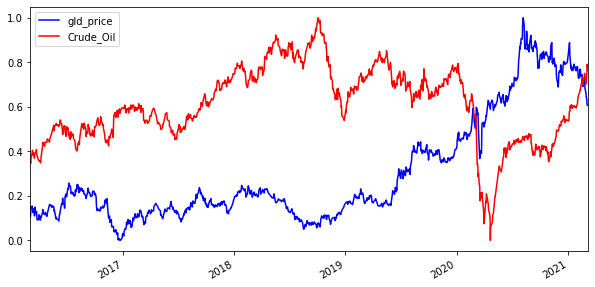

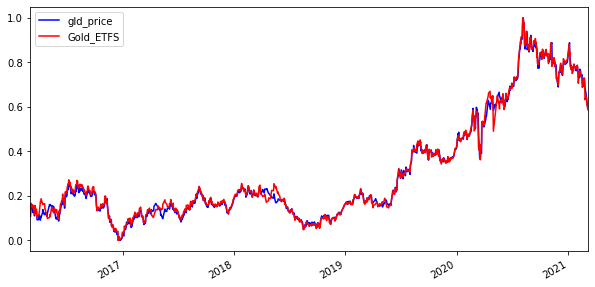

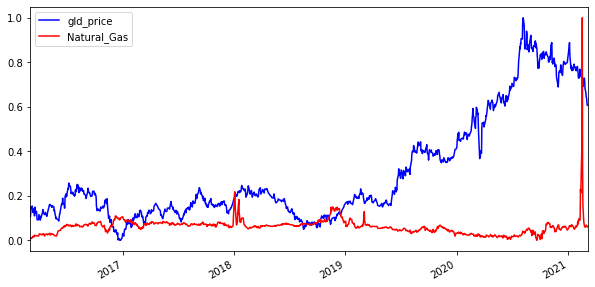

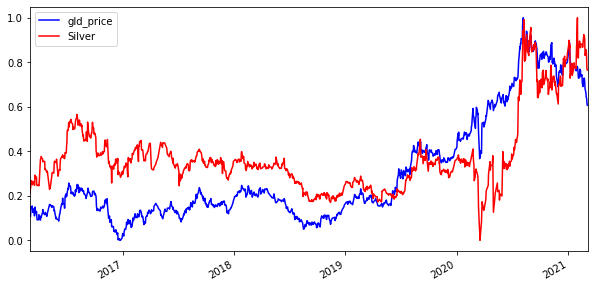

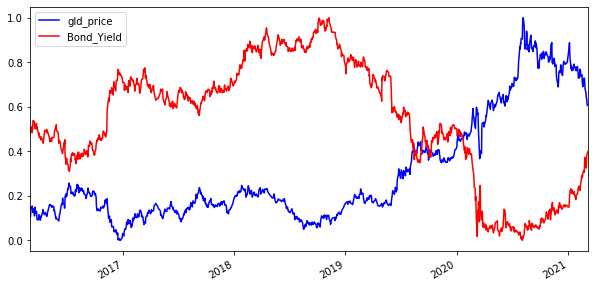

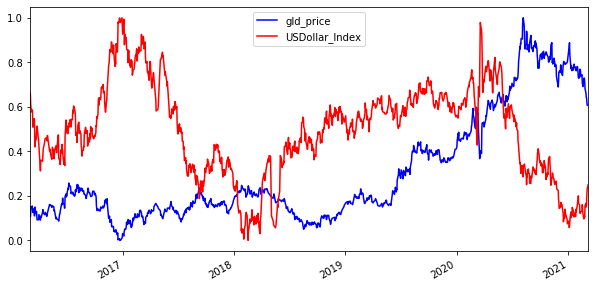

In [67]:
#plot all feature
for i in data.columns:
    if i != 'gld_price':
        plot_df(data,i)

In [68]:
z_scores = stats.zscore(data)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]

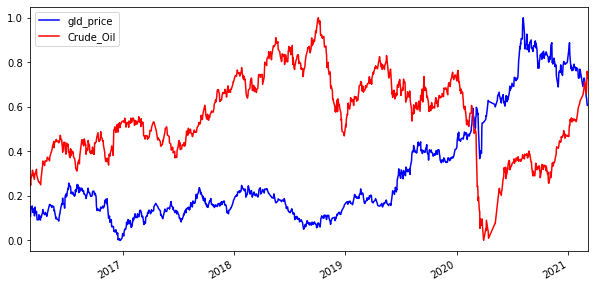

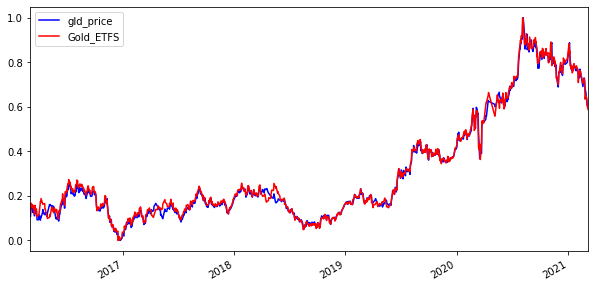

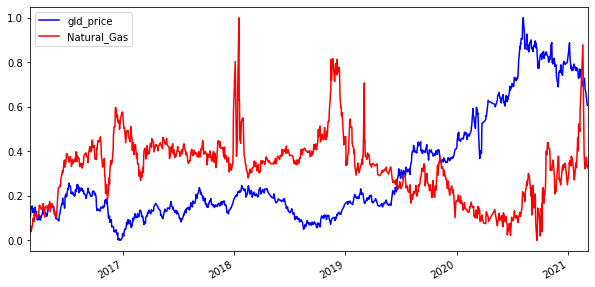

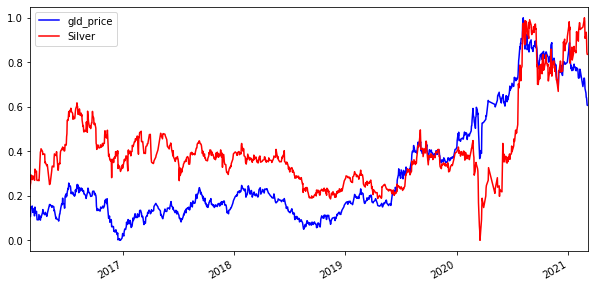

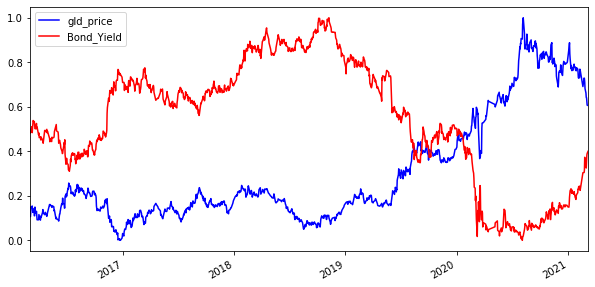

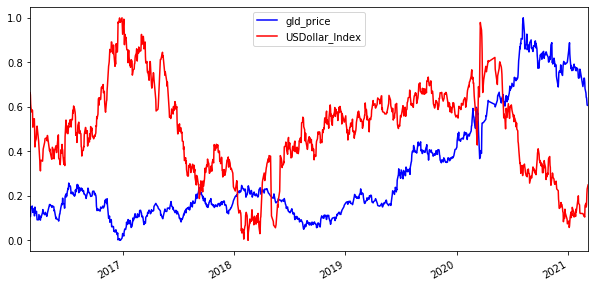

In [69]:
#plot all feature
for i in data.columns:
    if i != 'gld_price':
        plot_df(data,i)

## Correlation

In [70]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,gld_price,Crude_Oil,Gold_ETFS,Natural_Gas,Silver,Bond_Yield,USDollar_Index
gld_price,1,-0.401372,0.99793,-0.50196,0.728798,-0.841937,-0.284992
Crude_Oil,-0.401372,1,-0.414919,0.412359,-0.36827,0.73266,-0.188333
Gold_ETFS,0.99793,-0.414919,1,-0.505693,0.738432,-0.850269,-0.287657
Natural_Gas,-0.50196,0.412359,-0.505693,1,-0.13508,0.621973,-0.0487455
Silver,0.728798,-0.36827,0.738432,-0.13508,1,-0.635751,-0.417365
Bond_Yield,-0.841937,0.73266,-0.850269,0.621973,-0.635751,1,0.0309253
USDollar_Index,-0.284992,-0.188333,-0.287657,-0.0487455,-0.417365,0.0309253,1


In [71]:
granger = grangers_causation_matrix(data, variables = data.columns)

In [72]:
granger

,gld_price_x,Crude_Oil_x,Gold_ETFS_x,Natural_Gas_x,Silver_x,Bond_Yield_x,USDollar_Index_x
gld_price_y,1.0000,0.0786,0.0000,0.0671,0.0000,0.0000,0.0000
Crude_Oil_y,0.0352,1.0000,0.4213,0.5553,0.2640,0.0603,0.0499
Gold_ETFS_y,0.0000,0.1619,1.0000,0.0738,0.0000,0.0000,0.0001
Natural_Gas_y,0.0051,0.0477,0.0041,1.0000,0.1785,0.0002,0.6100
Silver_y,0.0036,0.0112,0.0000,0.1923,1.0000,0.0000,0.1258
Bond_Yield_y,0.0002,0.0103,0.0017,0.0190,0.0014,1.0000,0.0026
USDollar_Index_y,0.0742,0.0173,0.1121,0.6151,0.0398,0.0404,1.0000


In [73]:
## drop unusable  feature
data = data.drop(columns=[data.columns[i] for i in [1,6]])

In [74]:
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "gld_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.5777
 No. Lags Chosen       = 12
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.8759. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Gold_ETFS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.9369
 No. Lags Chosen       = 0
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.7756. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Natural_Gas" 
    -----------------------------------------------
 Null Hypothesis

In [75]:
## 1st Diff
df_diff = data.diff().dropna()

In [76]:
for name, column in df_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "gld_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8657
 No. Lags Chosen       = 11
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Gold_ETFS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.9585
 No. Lags Chosen       = 1
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Natural_Gas" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

In [77]:
x = df_diff[df_diff.index<'2021-03-01']
y = df_diff[df_diff.index>='2021-03-01']

In [78]:
y

,gld_price,Gold_ETFS,Natural_Gas,Silver,Bond_Yield
2021-03-01,-18.15,1.26,0.04,0.238,0.019
2021-03-02,-18.45,-0.71,0.17,0.201,-0.028
2021-03-03,-1.45,-0.49,-0.01,-0.492,0.086
2021-03-04,-17.00,-0.60,-0.07,-0.926,0.073
2021-03-05,-14.00,-1.93,-0.07,-0.174,0.020
2021-03-08,-1.60,-1.49,-0.05,-0.018,0.026


In [79]:
nobs = 6
n = len(x)
pred = pd.DataFrame()
df_x = x
df_y = y
model = VAR(df_x)
aic = {'n': 1, 'value':model.fit(1).aic}
for j in range(5,15):
    result = model.fit(j)
    if result.aic < aic['value']:
        aic['n'] = j
        aic['value'] = result.aic
print(aic)
model_fitted = model.fit(11)
lag_order = model_fitted.k_ar
forecast_input = df_diff.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_y.index[-nobs:], columns=df_diff.columns + '_1d')
df_results = invert_transformation(data[-7:], df_forecast, second_diff=False)  
pred = pred.append(df_results.loc[:, ['gld_price_forecast']])

{'n': 6, 'value': -7.010690834907333}


C:\Users\MSI\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [80]:
test_data = pd.DataFrame(data[-6:]['gld_price'])

In [81]:
change_trend_cal(pred)
change_trend_cal(test_data)

In [82]:
test_data

,gld_price,%Change,Trend
2021-03-01,1746.95,0.000000,0.0
2021-03-02,1728.50,-1.056126,-1.0
2021-03-03,1727.05,-0.083888,-1.0
2021-03-04,1710.05,-0.984337,-1.0
2021-03-05,1696.05,-0.818690,-1.0
2021-03-08,1694.45,-0.094337,-1.0


In [83]:
pred

,gld_price_forecast,%Change,Trend
2021-03-01,1675.023333,0.000000,0.0
2021-03-02,1684.549493,0.568718,1.0
2021-03-03,1691.821634,0.431697,1.0
2021-03-04,1696.520310,0.277729,1.0
2021-03-05,1698.599574,0.122561,1.0
2021-03-08,1697.623465,-0.057466,-1.0


<function matplotlib.pyplot.show(*args, **kw)>

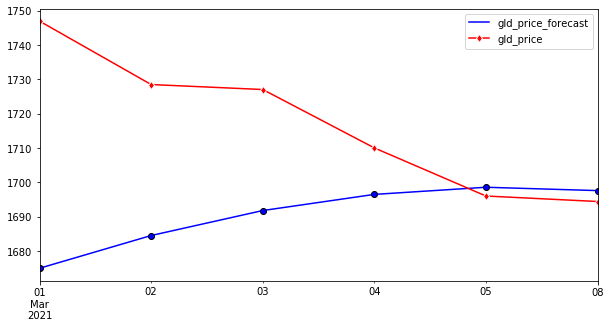

In [84]:
ax = plt.gca()
pred.plot(kind='line', y='gld_price_forecast',ax=ax,color='blue',figsize=(10,5),marker='o',markeredgecolor="black")
test_data.plot(kind='line', y='gld_price',ax=ax,color='red',marker='d',markeredgecolor="white")
plt.show

In [85]:
print('Forecast Accuracy of: gld_price')
accuracy_prod = forecast_accuracy(pred['gld_price_forecast'].values, test_data['gld_price'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: gld_price
mape :  0.0164
me :  -26.4854
mae :  28.393
mpe :  -0.0153
rmse :  37.7398
corr :  -0.933
minmax :  0.0164
